In [2]:
import ROOT
import numpy as np
#from root_numpy import random_sample
from scipy.ndimage import uniform_filter
import time
import matplotlib.pyplot as plt
import multiprocessing as mp

Welcome to JupyROOT 6.14/00


<h1>Simulation Model</h1>


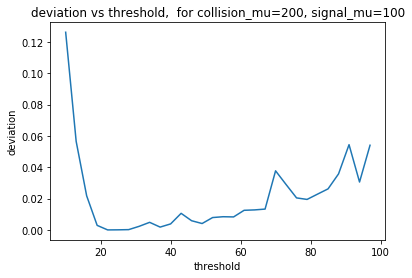

/usr/lib64/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Simulation took 1.5 seconds


In [7]:
# the constants of the constants. Pretty much choose once and leave it. Do not change.
C_total_channels = int(3.6 * 1e6)
C_channels_per_module = int(15*30)
C_total_modules = int(C_total_channels/C_channels_per_module)

# skip
#C_max_radius = 1

### Skipping radius dependency for now...


#==============================================================================

### Code for the simulation:

class parameter_object:
    # This might look cleaner, but it is less understood exactly what type of parameters and how many each function needs.
    # I don't think I will implement the usage of this, (yet at least)
    def __init__(self):
        pass

class noise_generator:
    def __init__(self, threshold, channel_count): # channel_count = C_total_channels
        global global_counter
        low = 0
        high = 1000
        noise = ROOT.TF1("noise_gauss", "TMath::Gaus(x, 0, 5)", low, high)
        self._mean = channel_count * noise.Integral(threshold, high)/noise.Integral(low, high)/2
        #self._prng = ROOT.TRandom3(time.time_ns())
        global_counter += 1
        self._prng = ROOT.TRandom3(int(time.time()) + global_counter)

    def generate(self):
        """The first return value is the exact number of noise activated channels in the small window and
            the second return value is the estimated number of noise activated channels in the small window. (estimated from large window)
            (both results are in small window, both results are noise above threshold)
            noise_exact, noise_est = noise.generate()"""
        # Large time window 25ns
        # Small time window 3.125ns
        prng = self._prng
        total = prng.Poisson(self._mean) # number of noise above threshold in large window in this run.
        narrow_exact = 0
        if total <= 5:
            for i in range(total):
                if prng.Uniform(25) < 3.125:
                    narrow_exact += 1
        else:
            # faster to use numpy
            #narrow_exact = (np.random.uniform(low=0, high=25, size=total) < 3.125).sum()
            narrow_exact = (np.random.rand(total) < 0.125).sum()  # 3.125/25 = 0.125
        
        noise_per_time = (total - narrow_exact)/(25 - 3.125)
        estimate = 3.125 * noise_per_time
        return narrow_exact, estimate

    
class signal_generator:
    def __init__(self, threshold, expected_voltage): # expected_voltage = expected peak voltage  (mu)
        global global_counter
        low = -100
        high = 1000
        self._threshold = threshold
        self._expected_voltage = expected_voltage
        signal_func = ROOT.TF1("sth", "TMath::Landau(x, %f, %f)" % (expected_voltage, expected_voltage/4), low, high)
        self.fraction_above = signal_func.Integral(threshold, high)/signal_func.Integral(low, high)
        #self._prng = ROOT.TRandom3(time.time_ns())
        global_counter += 1
        self._prng = ROOT.TRandom3(int(time.time()) + global_counter)
    
    def generate(self, expected_count):
        """The paramater is the expected number of particles that reach the detector.
            The first return value is the number of particles that reached the detector and
            the second return value is the number of activated channels.
            signal_real_total, signal_above = signal.generate(30)"""
        prng = self._prng
        expected_voltage = self._expected_voltage
        threshold = self._threshold
        
        signal_count = prng.Poisson(expected_count)
        above_threshold_count = 0
        sigma = expected_voltage/4
        for i in range(signal_count):
            if prng.Landau(expected_voltage, sigma) > threshold: # 1/4 is just the refernce 25/100
                above_threshold_count += 1
        return signal_count, above_threshold_count
    


def simulation_get_counts(bunch_crossing_count , ratio_of_channels_to_sample, signal_to_channel_count_ratio, threshold, signal_mu):
    """Runs a simulation over specified number of BC, and returns two lists:
        total_actual_signal_count and total_estimated_signal_count for each BC"""

    channel_count = get_number_of_channel_readouts(ratio_of_channels_to_sample)
    avg_particles_reaching_detector = channel_count * signal_to_channel_count_ratio
    peak_signal_voltage = signal_mu
    
    noise_gen = noise_generator(threshold, channel_count)
    signal_gen = signal_generator(threshold, peak_signal_voltage)
    
    result_actual_signal_count = np.zeros(bunch_crossing_count)
    result_estimated_signal_count = np.zeros(bunch_crossing_count)
    
    for BC in range(bunch_crossing_count):
        # The first return value is the exact number of noise activated channels in the small window and
        # the second return value is the estimated number of noise activated channels in the small window (estimated from large window).
        # (both results are in small window, both results are noise above threshold)
        noise_exact, noise_est = noise_gen.generate()
        
        # The paramater is the expected number of particles that reach the detector.
        # The first return value is the number of particles that reached the detector and 
        # the second return value is the number of activated channels.
        total_actual_signal, signal_above = signal_gen.generate(avg_particles_reaching_detector)
        
        # from the total, estimate how much total signal there was
        total_activations = signal_above + noise_exact  # total activations in small window (i.e. above threshold)
        total_signal_est = (total_activations - noise_est)/signal_gen.fraction_above

        # asign the results
        result_actual_signal_count[BC] = total_actual_signal
        result_estimated_signal_count[BC] = total_signal_est

    return result_actual_signal_count, result_estimated_signal_count
# we don't need to know the noise. Therefore not returing the noise values

def simulation_parallel_get_counts(number_of_BC, ratio_of_channels_to_sample, signal_to_channel_count_ratio, threshold, signal_mu):
    """Runs the simulations in parallel inorder to faster simulate. It then combines each result.
        and returns two lists: total_actual_signal_count and total_estimated_signal_count for each BC"""
    global global_counter
   # parameters for the simulation
    bins_of_BC = eq_div_strict(number_of_BC, nprocs)
    param_list = [ (bins_of_BC[i],  # number of BC for each parallel simulation
                    ratio_of_channels_to_sample,
                    signal_to_channel_count_ratio,
                    threshold,
                    signal_mu)
                 for i in range(nprocs)]
   # parallel simulation
    results = np.asarray(pool.starmap(simulation_get_counts, param_list))
    results = np.hstack(results).squeeze() # reshape

    result_actual_signal_count = results[0]
    result_estimated_signal_count = results[1]

   # list of count,  count for each bunch crossing event
    return result_actual_signal_count, result_estimated_signal_count



def get_listed_deviation_from_expected(result_actual_signal_count, result_estimated_signal_count):
    """Get the deviation from the simulated signals vs the expected signals as a list for each BC.
        Returns the deviation for each BC as a list of positive numbers"""
    deviation_list = np.abs( np.divide(result_estimated_signal_count, result_actual_signal_count) - 1 )
    return deviation_list
    
def get_total_deviation_from_expected(result_actual_signal_count, result_estimated_signal_count):
    """Get the total deviation from the total simulated signals vs the expected signals.
        Returns both the total deviation as a positive number"""
    total_deviation = abs( result_estimated_signal_count.sum() / result_actual_signal_count.sum() - 1 )
    return total_deviation

def get_absolute_total_deviation_from_expected(result_actual_signal_count, result_estimated_signal_count):
    """Get the absolute deviation as a difference between the [total actual signal] and [total estimated signal]"""
    total_absolute_deviation = abs(result_estimated_signal_count.sum() - result_actual_signal_count.sum())
    return total_absolute_deviation

def get_total_deviation_from_expected_with_simulated_results(number_of_BC, ratio_of_channels_to_sample, signal_to_channel_count_ratio, threshold, signal_mu):
    """Small helper method to pipe the simulation results into the deviation calculation directly."""
    result_actual_signal_count, result_estimated_signal_count = simulation_parallel_get_counts(number_of_BC, ratio_of_channels_to_sample, signal_to_channel_count_ratio, threshold, signal_mu)
    #result_actual_signal_count, result_estimated_signal_count = simulation_get_counts(number_of_BC, ratio_of_channels_to_sample, signal_to_channel_count_ratio, threshold, signal_mu)
    return get_total_deviation_from_expected(result_actual_signal_count, result_estimated_signal_count)
    

def get_the_best_threshold_and_deviation_in_terms_of_least_deviation(list_of_thresholds_to_try, number_of_BC, ratio_of_channels_to_sample, signal_to_channel_count_ratio, signal_mu):
    """Simulates for each threshold provided in list, tests which threshold has the least deviation in computed vs expected.
        and returns the best threshold it has found, also returns the deviation.
        ASLO SEE THE FUNCTION "get_the_best_threshold_and_deviation_in_terms_of_least_average_deviation"
        """
    # should not contain too large steps.
    list_of_thresholds_to_try = list(list_of_thresholds_to_try) # enforce list
    # calculate deviation for each simulation for each threshold
    deviation_iter = ([
        get_total_deviation_from_expected_with_simulated_results(
            number_of_BC,
            ratio_of_channels_to_sample,
            signal_to_channel_count_ratio,
            threshold,
            signal_mu)
        for threshold in list_of_thresholds_to_try])
    deviations = np.fromiter(deviation_iter, dtype=np.float, count=len(list_of_thresholds_to_try))
    
    # Blur the deviations,  assumes deviations follow a smooth curve.
    # The actuall minimum should not be discarded because of a random deviation, therefore blur.
    size = 5  # default is 3,  might want to change to 3
    deviations_blur = uniform_filter(deviations, size=size)#[1:-1] # nah no need to slice, the boundary error doesn't bother us
    
    # get the minimum
    index = np.argmin(deviations_blur)
    threshold = list_of_thresholds_to_try[index]
    deviation = deviations[index]
    
    return threshold, deviation

def get_the_best_threshold_in_terms_of_least_deviation(list_of_thresholds_to_try, number_of_BC, ratio_of_channels_to_sample, signal_to_channel_count_ratio, signal_mu):
    """Same as above, except it only returns the threshold"""
    threshold, deviation = get_the_best_threshold_and_deviation_in_terms_of_least_deviation(list_of_thresholds_to_try, number_of_BC, ratio_of_channels_to_sample, signal_to_channel_count_ratio, signal_mu)
    return threshold


def caluclate_SB(expected_signal_voltage, noise_sigma):
    """Formula for calculating S/B"""
    return expected_signal_voltage / noise_sigma

def calculate_expected_signal_voltage(signal_mu):
    """Some method to calculate the expected signal voltage for provided signal_mu and sigma"""
    
    # INTEGRATION METHOD:  (not used)
        # Use the definition:  ∫(x*f(x))dx
    """
        signal_sigma = signal_mu/4  # get_signal_sigma_for_mu(signal_mu)
        low = 0  # There are no particles hitting the detector with negative energies.
        high = 500
        fSignalEnergy = ROOT.TF1("Signal", "TMath::Landau(x, %f, %f)*x" % (signal_mu, signal_sigma), low, high)
        scale = 1  # 0.001  # mili, no, sigma is also in mV so it doesn't matter
        return fSignalEnergy.Integral(low, high) * scale
    """
    # ASSUME MU IS THE EXPECTED VALUE:  (currently used)
    return signal_mu

def calculate_list_of_SB_from_list_of_signal_mu(noise_sigma, iterator_mu, steps):
    """Returns a list of calculated S/B for a list of signal mu."""
    return np.fromiter(
                map(lambda signal_mu : caluclate_SB(
                        calculate_expected_signal_voltage(signal_mu),
                        noise_sigma) ,
                    iterator_mu)
             , dtype=np.float, count=steps)

def compute_list_of_least_deviation_from_list_of_signal_mu(number_of_BC, ratio_of_channels_to_sample, signal_to_channel_count_ratio, linspace_data_thresholds, linspace_data_signal_mu, number_of_mu_steps):
    """It will try a lot of thresholds provided for each signal_mu provided,
        and get the best result from the threasholds and put that least deviation result in a list for each signal mu.
        ALSO: SEE THE FUNCTION NAMED  "compute_list_of_least_average_deviation_from_list_of_signal_mu"
        """
    return np.fromiter(
                 map(lambda signal_mu :
                         get_the_best_threshold_and_deviation_in_terms_of_least_deviation(
                             linspace(*linspace_data_thresholds),  # list_of_thresholds_to_try
                             number_of_BC,
                             ratio_of_channels_to_sample,
                             signal_to_channel_count_ratio,
                             signal_mu)[1] ,  # deviation is at index 1
                         linspace(*linspace_data_signal_mu))
                 , dtype=np.float, count=number_of_mu_steps)

def compute_list_of_best_thresholds_from_list_of_signal_mu(number_of_BC, ratio_of_channels_to_sample, signal_to_channel_count_ratio, linspace_data_thresholds, linspace_data_signal_mu, number_of_mu_steps):
    """It will try a lot of thresholds provided for each signal_mu provided,
        and get the best result threasholds from the least deviation,
        and put that threasholds in a list for each signal mu."""
    return np.fromiter(
                 map(lambda signal_mu :
                         get_the_best_threshold_in_terms_of_least_deviation(
                             linspace(*linspace_data_thresholds),  # list_of_thresholds_to_try
                             number_of_BC,
                             ratio_of_channels_to_sample,
                             signal_to_channel_count_ratio,
                             signal_mu) ,  
                         linspace(*linspace_data_signal_mu))
                 , dtype=np.float, count=number_of_mu_steps)


def compute_average_deviation_from_simulations(simulation_samples, number_of_BC, ratio_of_channels_to_sample, signal_to_channel_count_ratio, signal_mu, threshold):
    """This function will compute a more statistical accurate deviation from the parameters given.
       It does this by simulating multiple times and takes the average deviation from those simulations.
        simulation_samples = how many simulations to run for the statistics
        number_of_BC = how many BC to run for each single simulation
        ratio_of_channels_to_sample = the scale of the simulation,  1.0 = full scale.
        average_collisions_mu = average number of collisions per bunch crossing.
        signal_mu = average energy of the signal
        threshold = threshold of the detector in for the simulations.
    """
    
    # makes diviation list
    deviations = np.zeros(simulation_samples)
    
    # makes multiple simulations and stores the deviation for each simulation
    for i in range(simulation_samples):
        deviations[i] = get_total_deviation_from_expected_with_simulated_results(
                number_of_BC,
                ratio_of_channels_to_sample,
                signal_to_channel_count_ratio,
                threshold,
                signal_mu
            )
    
    # takes the mean deviation found,  other intesting statistics can be made: e.g.  variance:  deviations.var()
    the_mean_deviation = deviations.mean()
    
    # print statistics
    #print_count_statistics(deviations)  # commented because not needed.
    
    return the_mean_deviation

def compute_list_of_least_average_deviation_from_list_of_signal_mu(simulation_samples, number_of_BC, ratio_of_channels_to_sample, signal_to_channel_count_ratio, linspace_data_thresholds, linspace_data_signal_mu, number_of_mu_steps):
    """It will try a lot of thresholds provided for each signal_mu provided,
        and get the best result from the threasholds and put that least deviation result in a list for each signal mu."""
    return np.fromiter(
                 map(lambda signal_mu :
                         get_the_best_threshold_and_deviation_in_terms_of_least_average_deviation(
                             simulation_samples,
                             linspace(*linspace_data_thresholds),  # list_of_thresholds_to_try
                             number_of_BC,
                             ratio_of_channels_to_sample,
                             signal_to_channel_count_ratio,
                             signal_mu)[1] ,  # deviation is at index 1
                         linspace(*linspace_data_signal_mu))
                     , dtype=np.float, count=number_of_mu_steps)

def get_the_best_threshold_and_deviation_in_terms_of_least_average_deviation(simulation_samples, list_of_thresholds_to_try, number_of_BC, ratio_of_channels_to_sample, signal_to_channel_count_ratio, signal_mu):
    """Simulates for each threshold provided in list, tests which threshold has the least deviation in computed vs expected.
        and returns the best threshold it has found, also returns the deviation."""
    # should not contain too large steps.
    list_of_thresholds_to_try = list(list_of_thresholds_to_try) # enforce list
    # calculate deviation for each simulation for each threshold
    deviation_iter = ([
        compute_average_deviation_from_simulations(
            simulation_samples,
            number_of_BC,
            ratio_of_channels_to_sample,
            signal_to_channel_count_ratio,
            signal_mu, 
            threshold)
        for threshold in list_of_thresholds_to_try])
    deviations = np.fromiter(deviation_iter, dtype=np.float, count=len(list_of_thresholds_to_try))
    
    # Blur the deviations,  assumes deviations follow a smooth curve.
    # The actuall minimum should not be discarded because of a random deviation, therefore blur.
    size = 5  # default is 3,  might want to change to 3
    deviations_blur = uniform_filter(deviations, size=size)#[1:-1] # nah no need to slice, the boundary error doesn't bother us
    
    # get the minimum
    index = np.argmin(deviations_blur)
    threshold = list_of_thresholds_to_try[index]
    deviation = deviations[index]
    
    return threshold, deviation
        
def compute_best_statistical_threshold_with_least_deviation_from_collision_and_signal_mu(simulation_samples, number_of_BC, ratio_of_channels_to_sample, average_collisions_mu, signal_mu, max_threshold, min_threshold, steps_threshold):
    """This function will compute the statistical best threshold from [simulation_samples] number of simulations.
       That way you get higher accuracy for the threshold and deviation.
        simulation_samples = how many simulations to run for the statistics
        number_of_BC = how many BC to run for each single simulation
        ratio_of_channels_to_sample = the scale of the simulation,  1.0 = full scale.
        average_collisions_mu = average number of collisions per bunch crossing.
        signal_mu = average energy of the signal
        max_threshold = highest threshold to test.
        min_threshold = lowest threshold to test.
        steps_threshold = how many steps inbetween [min_threshold] and [max_threshold].
        RETURNS: the best threshold found from the [simulation_samples], and it's average deviation.
    """
    
    # set average_collisions_mu
    signal_to_channel_count_ratio = get_signal_to_channel_count_ratio(
                                        collisions_per_BC = average_collisions_mu, # here we set it.
                                        particles_per_collision = 500,
                                        ratio_of_particles_reaching_HGTD=0.1) # some example value, idk if it matters
    
    # threshold to try, should not contain too large steps.
    list_of_thresholds_to_try = list(linspace(min_threshold, max_threshold, steps_threshold))
    
    # makes diviation list
    deviations = np.zeros(len(list_of_thresholds_to_try))
    
    # simulates multiple times and sums the deviations
    for i in range(simulation_samples):
        # calculate deviation for each threshold by simulating with the given parameters
        deviation_iter = ([
            get_total_deviation_from_expected_with_simulated_results(
                number_of_BC,
                ratio_of_channels_to_sample,
                signal_to_channel_count_ratio,
                threshold,
                signal_mu)
            for threshold in list_of_thresholds_to_try])
        # adds all deviations together.
        deviations += np.fromiter(deviation_iter, dtype=np.float, count=len(list_of_thresholds_to_try))
    
    # now we have summed up deviations from multiple simulations [simulation_samples]
    # and it is time to find the element with least deviaiton
    
    # Blur the deviations,  assumes deviations follow a smooth curve.
    # The actuall minimum should not be discarded because of a random deviation, therefore blur.
    size = 5  # default is 3,  might want to change to 3
    deviations_blur = uniform_filter(deviations, size=size)#[1:-1] # nah no need to slice, the boundary error doesn't bother us
    #deviations_blur = deviations  # turns off the blur. No we want blur.
    
    # get the minimum / least deviaiton
    index = np.argmin(deviations_blur)
    threshold = list_of_thresholds_to_try[index]
    deviation = deviations[index] / simulation_samples  # we have to divide it to get the average, since we summed it before.
    
    # returns the threshold found with least deviation, and it's deviation
    return threshold, deviation



# -End of simulation code-

#==============================================================================

### Code for the plots:

def plot_deviation_vs_SB():
    """Plots deviation vs S/B. See settings below to calibrate the simulation"""
    ## Simulator Settings:
    ratio_of_channels_to_sample = 1.0  # scale of simulation,   0.001 = small fast,   1.0 = full scale slow.
    number_of_BC = mp.cpu_count() * 10 # * 120
    
    simulation_samples = 10 # 10
    
    signal_to_channel_count_ratio = get_signal_to_channel_count_ratio()
    noise_sigma = 5  #mv
    
    min_signal_mu = 5  #mv  # cannot be below 0
    max_signal_mu = 30 #mv
    steps_signal_mu = (max_signal_mu - min_signal_mu) * 1   # resolution
    #steps_signal_mu = 20
    
    min_threshold = 2  #mv  # cannot be below 0
    max_threshold = 32 #mv
    steps_threshold = (max_threshold - min_threshold) * 1   # resolution

    ## Simulate, get data:
    #signal_mu_list = list(linspace(min_signal_mu, max_signal_mu, steps_signal_mu)) # can be used to plot
    SB = calculate_list_of_SB_from_list_of_signal_mu(
            noise_sigma,
            linspace(min_signal_mu, max_signal_mu, steps_signal_mu),
            steps_signal_mu
        )
    
    linspace_data_signal_mu = (min_signal_mu, max_signal_mu, steps_signal_mu)
    linspace_data_thresholds = (min_threshold, max_threshold, steps_threshold)
    
    deviations = compute_list_of_least_average_deviation_from_list_of_signal_mu(
            simulation_samples,
            number_of_BC,
            ratio_of_channels_to_sample,
            signal_to_channel_count_ratio,
            linspace_data_thresholds,
            linspace_data_signal_mu,
            steps_signal_mu
        )
    runs = 10
    for _ in range(runs-1):
        deviations += compute_list_of_least_average_deviation_from_list_of_signal_mu(
            simulation_samples,
            number_of_BC,
            ratio_of_channels_to_sample,
            signal_to_channel_count_ratio,
            linspace_data_thresholds,
            linspace_data_signal_mu,
            steps_signal_mu
        )
    deviations = np.divide(deviations, runs)
    
    #deviations_log = np.log(deviations)
    
    # print data
    print(deviations)
    ## Plot:
    x_list = SB
    y_list = deviations
    title = "Deviations vs SNR"
    prefix_filename = "Deviations_vs_SB_with_newNoise_BC" + str(number_of_BC)
    xlabel = "SNR"
    ylabel = "Deviations"
    make_integer_axis = False
    make_margin = False
    plot_the_data(title, prefix_filename, xlabel, ylabel, make_integer_axis, make_margin, x_list, y_list)
    

def plot3D_threshold_and_SB_vs_deviation():
    """Creates a 3D plot of threshold and S/B vs deviaiton"""
    ## Simulator Settings:
    ratio_of_channels_to_sample = 0.01  # scale of simulation,   0.001 = small fast,   1.0 = full scale slow.
    number_of_BC = mp.cpu_count() * 1
    
    signal_to_channel_count_ratio = get_signal_to_channel_count_ratio()
    noise_sigma = 5  #mv
    
    min_signal_mu = 15  #mv  # cannot be below 0
    max_signal_mu = 40 #mv
    steps_signal_mu = (max_signal_mu - min_signal_mu) * 1   # resolution
    
    min_threshold = 10  #mv  # cannot be below 0
    max_threshold = 80 #mv
    steps_threshold = (max_threshold - min_threshold) * 1   # resolution

    canvas = ROOT.TCanvas("c","Graph2D example",0,0,600,400)
    plot_threshold_SB_deviation = ROOT.TGraph2D()
    point_index = 0
    ## Simulate, get data:
    for loop_signal_mu in linspace(min_signal_mu, max_signal_mu, steps_signal_mu):
        for loop_treshold in linspace(min_threshold, max_threshold, steps_threshold):
            
            deviation = get_total_deviation_from_expected_with_simulated_results(
                            number_of_BC,
                            ratio_of_channels_to_sample,
                            signal_to_channel_count_ratio,
                            loop_treshold,
                            loop_signal_mu
                        )
            SB = caluclate_SB(calculate_expected_signal_voltage(loop_signal_mu), noise_sigma)
            
            plot_threshold_SB_deviation.SetPoint(point_index, SB, loop_treshold, deviation) # i, x, y, z
            point_index += 1
    
    
    plot_threshold_SB_deviation.SetTitle("Graph title; X axis title; Y axis title; Z axis title");
    plot_threshold_SB_deviation.Draw("surf1")
    canvas.Draw()
    print("done")

    
def plot_particle_intensity_mu_vs_best_threshold():    
    ## Simulator Settings:
    ratio_of_channels_to_sample = 1.0  # scale of simulation,   0.001 = small fast,   1.0 = full scale slow.
    number_of_BC = mp.cpu_count() * 8
    
    signal_mu = 50 # mv  # might want to change this
    
    min_threshold = 2  #mv  # cannot be below 0
    max_threshold = 80 #mv
    steps_threshold = (max_threshold - min_threshold) * 1   # resolution
    
    # important setting for this simulation
    min_intensity_mu = 0.008
    max_intensity_mu = 0.015
    steps_intensity_mu = (15-8)*3
    
    intensity_mu_list = list(linspace(min_intensity_mu, max_intensity_mu, steps_intensity_mu))
    threshold_list = np.zeros(len(intensity_mu_list))
    
    ## Simulate, get data:
    for index, collisions_per_BC in enumerate(intensity_mu_list):
        signal_to_channel_count_ratio = get_signal_to_channel_count_ratio(collisions_per_BC=collisions_per_BC)
        
        threshold, deviation = get_the_best_threshold_and_deviation_in_terms_of_least_deviation(
                        linspace(min_threshold, max_threshold, steps_threshold), #list_of_thresholds_to_try,
                        number_of_BC,
                        ratio_of_channels_to_sample,
                        signal_to_channel_count_ratio,
                        signal_mu
                    )
        threshold_list[index] = threshold
    
    # print result in list form
    print(threshold_list)
    
    ## Plot:
    x_list = intensity_mu_list
    y_list = threshold_list
    title = "threshold vs intensity_mu"
    prefix_filename = "threshold_vs_intensity_mu_with_BC" + str(number_of_BC)
    xlabel = "intensity_mu"
    ylabel = "threshold"
    make_integer_axis = True
    make_margin = False
    plot_the_data(title, prefix_filename, xlabel, ylabel, make_integer_axis, make_margin, x_list, y_list)
    

def plot_signal_mu_vs_best_threshold():
    ## Simulator Settings:
    ratio_of_channels_to_sample = 1.0  # scale of simulation,   0.001 = small fast,   1.0 = full scale slow.
    number_of_BC = mp.cpu_count() * 4
    
    signal_to_channel_count_ratio = get_signal_to_channel_count_ratio()
    
    noise_sigma = 5  #mv
    
    min_threshold = 2  #mv  # cannot be below 0
    max_threshold = 80 #mv
    steps_threshold = (max_threshold - min_threshold) * 1   # resolution
    
    min_signal_mu = 12  #mv  # cannot be below 0
    max_signal_mu = 40 #mv
    steps_signal_mu = (max_signal_mu - min_signal_mu) * 2   # resolution
    
    linspace_data_thresholds = (min_threshold, max_threshold, steps_threshold)
    linspace_data_signal_mu = (min_signal_mu, max_signal_mu, steps_signal_mu)
    
    ## Simulate, get data:
    signal_mu_list = list(linspace(*linspace_data_signal_mu))
    
    threshold_list = compute_list_of_best_thresholds_from_list_of_signal_mu(
        number_of_BC,
        ratio_of_channels_to_sample,
        signal_to_channel_count_ratio,
        noise_sigma,
        linspace_data_thresholds,
        linspace_data_signal_mu,
        steps_signal_mu
    )
    
    ## Plot:
    x_list = signal_mu_list
    y_list = threshold_list
    title = "threshold vs signal_mu"
    prefix_filename = "threshold_vs_signal_mu_with_BC" + str(number_of_BC)
    xlabel = "signal_mu"
    ylabel = "threshold"
    make_integer_axis = False
    make_margin = False
    plot_the_data(title, prefix_filename, xlabel, ylabel, make_integer_axis, make_margin, x_list, y_list)

    
def plot_deviation_vs_threshold(signal_mu, min_threshold, max_threshold, number_of_thresholds_to_try):
    """Plots deviation vs threshold for given mu."""
    ## Simulator Settings:
    ratio_of_channels_to_sample = 0.001  # scale of simulation,   0.001 = small fast,   1.0 = full scale slow.
    number_of_BC = mp.cpu_count() * 4
    
    signal_to_channel_count_ratio = get_signal_to_channel_count_ratio()

    steps_threshold = number_of_thresholds_to_try  # resolution, number of steps
    
    linspace_data_thresholds = np.linspace(min_threshold, max_threshold, steps_threshold)
    deviation_list = []    # Är append ett ineffektivt sätt att koda på?
    
    for threshold in linspace_data_thresholds:
        deviation_list.append(get_total_deviation_from_expected_with_simulated_results(
            number_of_BC, 
            ratio_of_channels_to_sample, 
            signal_to_channel_count_ratio, 
            threshold, 
            signal_mu
        ))
    
#     print(linspace_data_thresholds, deviation_list)
    
    ## Plot:
    x_list = linspace_data_thresholds
    y_list = deviation_list
    title = "deviation vs threshold for mu="+str(signal_mu)
    prefix_filename = "deviation_vs_threshold_with_BC" + str(number_of_BC)+"_mu"+str(signal_mu)
    xlabel = "threshold"
    ylabel = "deviation"
    make_integer_axis = True
    make_margin = False
    plot_the_data(title, prefix_filename, xlabel, ylabel, make_integer_axis, make_margin, x_list, y_list)

    
def plot_deviation_vs_threshold_2():
    # Rough estimate of calculation time:
    # It takes roughly:  40 seconds
        # with following settings:
        #  ratio_of_channels_to_sample = 1.0,   simulation_samples = 10,   number_of_BC = nprocs * 4
        #  steps_threshold = 30
    
    ratio_of_channels_to_sample = 1.0  # scale of simulation,   0.001 = small fast,   1.0 = full scale slow.
    
    # how many simulations to sample for the deviation. - larger = more accurate
    simulation_samples = 10
    
    # number of BC for each single simulation.
    number_of_BC = nprocs * 4   # (works best with a multiple of [nprocs], nprocs is about equal to 4 or 8)
    
    # intensity of collisions, average collisions per bunch crossing
    average_collisions_mu = 200
    # set average_collisions_mu
    signal_to_channel_count_ratio = get_signal_to_channel_count_ratio(
                                        collisions_per_BC = average_collisions_mu, # here we set it.
                                        particles_per_collision = 500,
                                        ratio_of_particles_reaching_HGTD=0.1) # some example value, idk if it matters
    
    # average energy of the signal
    signal_mu = 100
    
    # thresholds to use
    min_threshold = 10
    max_threshold = 100
    steps_threshold = 30   # resolution,  it takes longer time if you increase resolution. but the graph is better
    
    # make deviation list
    list_deviation = []
    list_threshold = list(linspace(min_threshold, max_threshold, steps_threshold))
    
    # here we loop over signal_mu
    # could also edit the code to have a fixed value singnal_mu and instead loop average_collisions_mu
    for threshold in list_threshold:
        # calculate the threshold and deviaiton
        deviation = compute_average_deviation_from_simulations(
                simulation_samples,
                number_of_BC,
                ratio_of_channels_to_sample,
                signal_to_channel_count_ratio,
                signal_mu,
                threshold
        )
        list_deviation.append(deviation)
        
    # print data
    #print(list_deviation)
    
    ## Plot:
    x_list = list_threshold
    y_list = list_deviation
    title = "deviation vs threshold,  for collision_mu=" + str(average_collisions_mu) + ", signal_mu=" + str(signal_mu)
    prefix_filename = "Deviation vs threshold_nr2_with_BC" + str(number_of_BC)
    xlabel = "threshold"
    ylabel = "deviation"
    make_integer_axis = False
    make_margin = False
    plot_the_data(title, prefix_filename, xlabel, ylabel, make_integer_axis, make_margin, x_list, y_list)

    
def plot_best_threshold_deviation_vs_signal_mu():
    # Rough estimate of calculation time:
    # It takes roughly:  900 seconds = 15 minuites
        # with following settings:
        #  ratio_of_channels_to_sample = 1.0,   simulation_samples = 10,   number_of_BC = nprocs * 4
        #  steps_threshold = 30,   steps_signal_mu = 25
    
    ratio_of_channels_to_sample = 1.0  # scale of simulation,   0.001 = small fast,   1.0 = full scale slow.
    
    # how many simulations to sample for the deviation. - larger = more accurate
    simulation_samples = 10 
    
    # number of BC for each single simulation.
    number_of_BC = nprocs * 4   # (works best with a multiple of [nprocs], nprocs is about equal to 4 or 8)
    
    # intensity of collisions, average collisions per bunch crossing
    average_collisions_mu = 200
    
    # threshold searches in the simulation (what thresholds to test deviation)
    min_threshold = 10
    max_threshold = 40
    steps_threshold = 30   # resolution,  it takes longer time if you increase resolution. but the graph is better
    
    # signal mu to loop,  (could also edit for fixed signal mu and loop average_collisions_mu instead)
    min_signal_mu = 5
    max_signal_mu = 100
    steps_signal_mu = 25
    list_signal_mu = list(linspace(min_signal_mu, max_signal_mu, steps_signal_mu))
    
    # create lists
    list_threshold = []
    
    # here we loop over signal_mu
    # could also edit the code to have a fixed value singnal_mu and instead loop average_collisions_mu
    for signal_mu in linspace(min_signal_mu, max_signal_mu, steps_signal_mu):
        # calculate the threshold and deviaiton
        threshold, deviation = compute_best_statistical_threshold_with_least_deviation_from_collision_and_signal_mu(
                simulation_samples,
                number_of_BC,
                ratio_of_channels_to_sample,
                average_collisions_mu,
                signal_mu,
                max_threshold,
                min_threshold,
                steps_threshold
            )
        list_threshold.append(threshold)
        
    # print data
    #print(list_threshold)
    
    ## Plot:
    x_list = list_signal_mu
    y_list = list_threshold
    title = "best threshold vs signal mu"
    prefix_filename = "Threshold_vs_signal_mu_with_BC" + str(number_of_BC)
    xlabel = "signal mu"
    ylabel = "threshold"
    make_integer_axis = False
    make_margin = False
    plot_the_data(title, prefix_filename, xlabel, ylabel, make_integer_axis, make_margin, x_list, y_list)
    

def plot_best_threshold_deviation_vs_BC_SLOW():
    
    ratio_of_channels_to_sample = 1.0  # scale of simulation,   0.001 = small fast,   1.0 = full scale slow.
    
    # how many simulations to sample for the deviation. - larger = more accurate
    simulation_samples = 1
    
    # initial number and steps
    number_of_BC = nprocs * 1   # (works best with a multiple of [nprocs], nprocs is about equal to 4 or 8)
    BC_steps = 3
    
    # intensity of collisions, average collisions per bunch crossing
    average_collisions_mu = 200
    
    # threshold searches in the simulation (what thresholds to test deviation)
    min_threshold = 20
    max_threshold = 30
    steps_threshold = 10   # resolution,  it takes longer time if you increase resolution. but the graph is better
    
    # signal mu to loop,  (could also edit for fixed signal mu and loop average_collisions_mu instead)
    signal_mu = 100
    
    # create lists
    list_threshold = []
    list_BC = []
    
    # loop for the number of BC to use (numBC)  and get the threshold for each BC
    # NOTE: THIS IS THE SLOW METHOD!  SEE THE OTHER FUNCTION BELOW 
    for i_numBC in range(BC_steps):
        numBC = number_of_BC + 48*i_numBC
        list_BC.append(numBC)
        
        # calculate the threshold and deviaiton
        threshold, deviation = compute_best_statistical_threshold_with_least_deviation_from_collision_and_signal_mu(
                simulation_samples,
                numBC,
                ratio_of_channels_to_sample,
                average_collisions_mu,
                signal_mu,
                max_threshold,
                min_threshold,
                steps_threshold
            )
        list_threshold.append(threshold)
        
    # print data
    print(list_threshold)
    
    ## Plot:
    x_list = list_BC
    y_list = list_threshold
    title = "best threshold vs number of bunch crossings"
    prefix_filename = "Threshold_vs_numbunch_slow"
    xlabel = "number of bunch crossings"
    ylabel = "threshold"
    make_integer_axis = False
    make_margin = False
    plot_the_data(title, prefix_filename, xlabel, ylabel, make_integer_axis, make_margin, x_list, y_list)
    
    
    #----------------------------------------------------------------------------------------------
def plot_best_threshold_deviation_vs_BC_custom_FAST():
    
    ratio_of_channels_to_sample = 1.0  # scale of simulation,   0.001 = small fast,   1.0 = full scale slow.
    
    # how many simulations to sample for the deviation. - larger = more accurate
    simulation_samples = 15
    
    # intensity of collisions, average collisions per bunch crossing
    average_collisions_mu = 200
    signal_to_channel_count_ratio = get_signal_to_channel_count_ratio(collisions_per_BC = average_collisions_mu)
    
    # threshold searches in the simulation (what thresholds to test deviation)
    min_threshold = 21
    max_threshold = 29
    steps_threshold = 8*4   # resolution,  it takes longer time if you increase resolution. but the graph is better
    
    # signal mu to loop,  (could also edit for fixed signal mu and loop average_collisions_mu instead)
    signal_mu = 100
    
    # number of BC (should be multiple of 8)
    #number_of_BC = 16*2
    #BC_steps = 15+1
    number_of_BC = 8000
    extra_BC = 800
    BC_steps = 20
    
    # the thresholds to use
    list_of_thresholds_to_try = list(linspace(min_threshold, max_threshold, steps_threshold))
    
    # long cache list of simulations
    list_of_results_i_threshold_i_samples = np.zeros(len(list_of_thresholds_to_try), dtype=np.ndarray)
    
    # simulate for each parameter and store in the chache
    for index, threshold in enumerate(list_of_thresholds_to_try):
        
        # makes diviation list
        simulations = np.zeros(simulation_samples, dtype=np.ndarray)

        # makes multiple simulations and stores the deviation for each simulation
        for i in range(simulation_samples):
            
            result_actual_signal_count, result_estimated_signal_count = simulation_parallel_get_counts(number_of_BC + extra_BC, ratio_of_channels_to_sample, signal_to_channel_count_ratio, threshold, signal_mu)
            simulations[i] = np.array([result_actual_signal_count, result_estimated_signal_count])
            
        list_of_results_i_threshold_i_samples[index] = simulations
        
    
    #print(list_of_results_i_threshold_i_samples)
    
    list_BC = []
    list_threshold = []
    
    # extract data from the cache simulations (list_of_results_i_threshold_i_samples)
    for i_BC in range(1, BC_steps+1):
        BC = int(number_of_BC/BC_steps * i_BC)
        list_BC.append(BC)
        
        deviations_per_t = np.zeros(len(list_of_thresholds_to_try))
        
        # make random table of index to extract random BC from
        N = number_of_BC + extra_BC
        K = BC # K ones, N-K zeros
        arr = np.array([1] * K + [0] * (N-K))
        
        # for each threshold extract
        for index, threshold in enumerate(list_of_thresholds_to_try):
        
            deviations = np.zeros(simulation_samples)
            
            for i in range(simulation_samples):
                # extract BCs
                np.random.shuffle(arr)
                result_actual_signal_count = list_of_results_i_threshold_i_samples[index][i][0][arr]
                result_estimated_signal_count = list_of_results_i_threshold_i_samples[index][i][1][arr]
                
                deviations[i] = get_total_deviation_from_expected(result_actual_signal_count, result_estimated_signal_count)

            the_mean_deviation = deviations.mean()
            
            deviations_per_t[index] = the_mean_deviation
            
        size = 5  # default is 3,  might want to change to 3
        deviations_t_blur = uniform_filter(deviations_per_t, size=size)#[1:-1] # nah no need to slice, the boundary error doesn't bother us

        # get the minimum
        index = np.argmin(deviations_t_blur)
        threshold = list_of_thresholds_to_try[index]
        deviation = deviations_per_t[index]
        
        # store the result
        list_threshold.append(threshold)
        
    
    
        
    # print data
    print(list_threshold)
    
    ## Plot:
    x_list = list_BC
    y_list = list_threshold
    title = "best threshold vs number of bunch crossings"
    prefix_filename = "Threshold_vs_numbunch_fast"
    xlabel = "number of bunch crossings"
    ylabel = "threshold"
    make_integer_axis = False
    make_margin = False
    plot_the_data(title, prefix_filename, xlabel, ylabel, make_integer_axis, make_margin, x_list, y_list)
    
    
    
def plot_the_data(title, prefix_filename, xlabel, ylabel, make_integer_axis, make_margin, x_list, y_list):
    timestr = time.strftime("%Y%m%d-%H%M%S")
    FILENAME = prefix_filename + "_(" + timestr + ").pdf"
    
    fig = plt.figure()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if make_integer_axis:
        plt.locator_params(axis="both", integer=True) # integer axis
    if make_margin:
        plt.margins(y=1)  # add margin to y
    
    plt.plot(x_list, y_list)
    plt.show()
    ax = fig.add_subplot(111)
    fig.savefig(FILENAME)
    #fig.savefig(FILENAME, dpi=200)  # use for png
    

    
# -End of plot code-
    
#==============================================================================

### Helper functions:

def eq_div(N, i):
    return int([N // i + 1] * (N % i) + [N // i] * (i - N % i))
def eq_div_strict(N, i):
    return [N // i] * i
def np_stats(np_list):
    """Use a list from e.g. simulaiton_combined_get_counts and get statistics about that list"""
    return np.mean(np_list), np.var(np_list), np.std(np_list)
def print_count_statistics(np_list):
    """Use a list from e.g. simulaiton_combined_get_counts and get statistics about that list"""
    mean, variance, standard_deviation = np_stats(np_list)
    print("mean:", mean)
    print("variance:", variance)
    print("standard_deviation:", standard_deviation)
def get_signal_sigma_for_mu(signal_mu):
    """Using references from the short paper, to calculate sigma"""
    reference_singal_mu = 100  # from s.15  (at threshold 40)
    reference_signal_sigma = 25  #mv  25 from reference for signal_mu = 100 (s.24)
    minimum = 0.01
    signal_sigma = minimum + reference_signal_sigma * (signal_mu/reference_singal_mu) 
    return signal_sigma
def get_signal_to_channel_count_ratio(collisions_per_BC = 50, particles_per_collision = 500, ratio_of_particles_reaching_HGTD=0.1):
    """Determines how many signals there will be,
        based from  collisions_per_BC,  particles_per_collision,  ratio_of_particles_reaching_HGTD"""
    #collisions_per_BC = 50
    #particles_per_collision = 500
    #ratio_of_particles_reaching_HGTD = 0.1
    signal_to_channel_count_ratio = collisions_per_BC * particles_per_collision * ratio_of_particles_reaching_HGTD / C_total_channels
    return signal_to_channel_count_ratio
def get_number_of_channel_readouts(ratio_of_channels_to_sample):
    """Returns the number of channels to read from - used to downscale simulation"""
    return int(C_total_channels * ratio_of_channels_to_sample)

def linspace(start, end, steps):
    scale = (end-start)/(steps)
    return map(lambda x : start + x*scale, range(steps)) # does not include the last value, since steps = length


# -End of helper functions-

#==============================================================================

###  Main code - what to run, what to plot, what do calculate

def main():
    # code... what to plot, what do calculate, ...
    
    #plot_best_threshold_deviation_vs_BC_custom_FAST()
    #plot_deviation_vs_SB()
    #plot3D_threshold_and_SB_vs_deviation()
    #plot_particle_intensity_mu_vs_best_threshold()
    #plot_signal_mu_vs_best_threshold()
    #plot_deviation_vs_threshold(0.01,0,0.03,100)
    #plot_best_threshold_deviation_vs_signal_mu()
    #plot_deviation_vs_threshold_2()
    
    
    # example simulation...
    result_actual_signal_count, result_estimated_signal_count = simulation_parallel_get_counts(
        number_of_BC = 100000,
        ratio_of_channels_to_sample = 1.0,
        signal_to_channel_count_ratio = get_signal_to_channel_count_ratio(collisions_per_BC = 200),
        threshold = 25,
        signal_mu = 50)
    
    # deviations as a list
    #deviation_list = get_listed_deviation_from_expected(result_actual_signal_count, result_estimated_signal_count)
    
    # standard deviation of the list of relative signal diviation.
    #print("standard deviation of %deviation:", deviation_list.std())
    
    
    # -code end-
    return




### Not important to understand ... it's just a startup script, see main() above instead.
if __name__ == '__main__':
    mp.freeze_support()
    
    # profiles to determine compute resources
    profiles = {"normal": 2, "fast": 4, "fastest": 99}
    max_processes = profiles["fastest"]  # edit this
    
    # setup pool
    nprocs = min(mp.cpu_count(), max_processes)
    pool = mp.Pool(processes=nprocs)
    
    global_counter = 0
    
    # run code
    t0 = time.time()
    main()
    t1 = time.time()
    print("Simulation took", round(t1-t0, 1), "seconds") # real time not the actuall process_time()
    
    # clean up
    pool.close()
    pool.join()



====================================================

# Notes



====================================================


<h1>Testing</h1>


In [ ]:
for i in range(signal_count):
    if prng.Landau(expected_voltage, expected_voltage/4) > threshold: # 1/4 is just the refernce 25/100
        above_threshold_count += 1